<a href="https://colab.research.google.com/github/jaiwon880/ML_Projiect/blob/main/web/%EC%95%84%ED%8C%8C%ED%8A%B8_%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_1%EC%9B%94_%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [ ]:
# INPUT : 도/면적/계약년월/건축년도/유형
# OUTPUT : 금액
# EX) 서울 /50 / 2020 / 직거래 → 100억?
# EX2) 경기도/ 30 / 1990/ 중개 → ???억

# 시군구 전처리 - ex) 경기도 OO군 OO시 → 경기도 df[’’].split(’ ‘)[0]
# 거래유형 전처리 - 중개 : 0 직 : 1
# 피쳐엔지니어링 - ex) 면적당 금액?

In [ ]:
#@title 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [120]:
#@title 시군구 - 전용면적, 계약년월, 거래 금액, 건축년도, 거래유형
df_apt1 = pd.read_csv('https://github.com/jaiwon880/ML_Projiect/raw/main/Data/%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%A7%A4%EB%A7%A4__%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_20230321134107_1%EC%9B%94.csv')
df_apt1
# df_apt2 = pd.read_excel('https://github.com/jaiwon880/ML_Projiect/raw/main/Data/%EC%95%84%ED%8C%8C%ED%8A%B8(%EB%A7%A4%EB%A7%A4)_%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_2%EC%9B%94.xlsx')
# df_apt2

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형
0,강원도 강릉시 견소동,84.930,202301,4,"25,000",1997.0,중개거래
1,강원도 강릉시 견소동,84.990,202301,5,"29,800",2005.0,중개거래
2,강원도 강릉시 견소동,84.990,202301,25,"28,500",2005.0,중개거래
3,강원도 강릉시 교동,59.860,202301,4,"20,000",2002.0,직거래
4,강원도 강릉시 교동,59.840,202301,11,"25,000",2002.0,중개거래
...,...,...,...,...,...,...,...
19997,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19998,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19999,충청북도 충주시 호암동,84.960,202301,8,"38,500",2019.0,중개거래
20000,충청북도 충주시 호암동,84.890,202301,16,"37,000",2019.0,중개거래


In [ ]:
# df_apt1[['시/도', '시군구', '읍면동', '리']] = df_apt1['시군구'].str.split(' ', n=4, expand=True)
# df_apt1.drop('시군구', axis=1, inplace=True)
# df_apt1

In [ ]:
df_apt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       20002 non-null  object 
 1   전용면적(㎡)   20002 non-null  float64
 2   계약년월      20002 non-null  int64  
 3   계약일       20002 non-null  int64  
 4   거래금액(만원)  20002 non-null  object 
 5   건축년도      19998 non-null  float64
 6   거래유형      20002 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ MB


In [ ]:
df_apt1.describe() # 54억 ^_^... 700마넌넌

,전용면적(㎡),계약년월,계약일,건축년도
count,20002.000000,20002.0,20002.000000,19998.000000
mean,73.051181,202301.0,16.970053,2006.036354
std,23.592464,0.0,8.730426,10.753980
min,11.790000,202301.0,1.000000,1968.000000
25%,59.775000,202301.0,10.000000,1997.000000
50%,75.303600,202301.0,17.000000,2006.000000
75%,84.950000,202301.0,26.000000,2017.000000
max,258.680000,202301.0,31.000000,2023.000000


In [ ]:
df_apt1['거래금액(만원)'].str.strip().replace(' ','')
df_apt1

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형
0,강원도 강릉시 견소동,84.930,202301,4,"25,000",1997.0,중개거래
1,강원도 강릉시 견소동,84.990,202301,5,"29,800",2005.0,중개거래
2,강원도 강릉시 견소동,84.990,202301,25,"28,500",2005.0,중개거래
3,강원도 강릉시 교동,59.860,202301,4,"20,000",2002.0,직거래
4,강원도 강릉시 교동,59.840,202301,11,"25,000",2002.0,중개거래
...,...,...,...,...,...,...,...
19997,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19998,충청북도 충주시 호암동,84.809,202301,10,"33,000",2019.0,중개거래
19999,충청북도 충주시 호암동,84.960,202301,8,"38,500",2019.0,중개거래
20000,충청북도 충주시 호암동,84.890,202301,16,"37,000",2019.0,중개거래


In [ ]:
#@title 평당가 금액
df_apt1["거래금액(만원)"] = df_apt1["거래금액(만원)"].str.replace(",", "").astype(int) # 거래금액 컬럼의 쉼표를 제거하고 정수형으로 변환
df_apt1["평당가"] = (df_apt1["거래금액(만원)"] / df_apt1["전용면적(㎡)"]) * 3.3 # 평당가 계산하여 새로운 컬럼 추가
df_apt1["평당가"]

0         971.388202
1        1157.077303
2        1106.600777
3        1102.572670
4        1378.676471
            ...     
19997    1284.061833
19998    1284.061833
19999    1495.409605
20000    1438.331959
20001    1584.745763
Name: 평당가, Length: 20002, dtype: float64

In [ ]:
df_apt1 = df_apt1.drop('시군구', axis=1)
df_apt1['거래유형'] = df_apt1['거래유형'].replace({'중개거래': 0, '직거래': 1})

In [ ]:
#@title 결측치 건축년도 4개 삭제 
df_apt1.isna().sum()
df_apt1.dropna(inplace=True)

In [ ]:
df_apt1.isna().sum()

In [ ]:
df_apt1['금리'] = df_apt1.apply(lambda x: 3.25 if ((x['계약년월']== 202301) & (x['계약일'] < 13)) else 3.5, axis=1)

In [ ]:
#@title 훈련셋 테스트셋 나누기

X = df_apt1.drop("거래금액(만원)", axis=1)
y = df_apt1[['거래금액(만원)']]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=100)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15998, 7) (4000, 7) (15998, 1) (4000, 1)


In [ ]:
#@title  선형회귀?

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse_error(y, y_pred):
  rmse = mean_squared_error(y, y_pred) ** 0.5
  return rmse

print(rmse_error(lr.predict(X_train),y_train))
print(rmse_error(lr.predict(X_test),y_test))

10358.790689409081
9624.119779614526


In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # 크롤링할 페이지 URL
# url = "https://www.google.com/search?q=2022%EB%85%84%2C+2023%EB%85%84+%EA%B8%B0%EC%A4%80%EA%B8%88%EB%A6%AC&oq=2022%EB%85%84%2C+2023%EB%85%84+%EA%B8%B0%EC%A4%80%EA%B8%88%EB%A6%AC&aqs=chrome..69i57j0i512l4j0i30j0i8i30l4.6905j1j7&sourceid=chrome&ie=UTF-8"

# # requests 라이브러리를 사용하여 HTML 코드 가져오기
# response = requests.get(url)
# html = response.text

# # BeautifulSoup 라이브러리를 사용하여 HTML 파싱
# soup = BeautifulSoup(html, "html.parser")

# # 최신 데이터 출력하기
# table = soup.find_all("table", {"class": "ztXv9"})

# for tr in table[0].find_all("tr"):
#     td_list = tr.find_all("td")
#     if len(td_list) == 5:
#         print(td_list[0].text.strip(), td_list[2].text.strip())

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

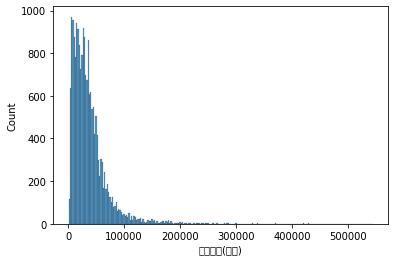

In [117]:
sns.histplot(df_apt1['거래금액(만원)'])
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


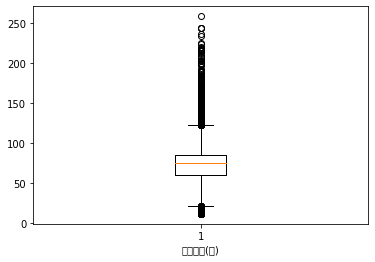

In [123]:
#@title 이상치

box=['전용면적(㎡)']

for i in box:
  plt.boxplot(df_apt1[i])
  plt.xlabel(i)
  plt.show()

In [ ]:
#@title get_dummies 쓰면. . . 이따구로 나와요 화가 나
# df_apt1_2 = pd.get_dummies(df_apt1, columns=df_apt1.describe(include='O').columns)
# df_apt1_2

In [ ]:
X = df_apt1.drop('거래금액(만원)', axis=1) 
y = df_apt1['거래금액(만원)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=230)